In [368]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes
from time import time

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RandomizedSearchCV, ShuffleSplit, train_test_split

properati = pd.read_csv('datos/caba_para_mapa.csv',error_bad_lines=False)

<IPython.core.display.Javascript object>

In [369]:
properati.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48323 entries, 0 to 48322
Data columns (total 26 columns):
created_on                    48323 non-null object
property_type                 48323 non-null object
place_name                    48323 non-null object
state_name                    48323 non-null object
lat-lon                       48323 non-null object
lat                           48323 non-null float64
lon                           48323 non-null float64
price                         48323 non-null float64
currency                      48323 non-null object
price_aprox_local_currency    48323 non-null float64
price_aprox_usd               48323 non-null float64
surface_total_in_m2           48323 non-null float64
surface_covered_in_m2         48323 non-null float64
price_usd_per_m2              48323 non-null float64
price_per_m2                  48323 non-null float64
floor                         6223 non-null float64
rooms                         33792 non-null float

In [370]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])
properati['anio'] = [x.year for x in properati['created_on'] ]

In [371]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=properati['place_name']
le_barrio.fit(barrios)
properati['place_name'] = le_barrio.transform(barrios)

le_divisa = preprocessing.LabelEncoder()
divisa=properati['currency']
le_divisa.fit(divisa)
properati['currency'] = le_divisa.transform(divisa)

le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)

###  Agrego features

### Pruebo con np.histogram

In [372]:
cant_buckets =50

#buckets
cantidad,rango = np.histogram(properati['price_usd_per_m2'], bins=cant_buckets)
print rango
properati['categories_by_price']=pd.cut(properati['price_per_m2'],rango,labels=np.arange(cant_buckets),include_lowest=True)
properati['price_range']=pd.cut(properati['price_per_m2'],rango)

properati.loc[properati['categories_by_price']!=properati['categories_by_price']]
#properati['categories_by_price']=pd.qcut(x=properati['price_per_m2'],q=cant_buckets,labels=np.arange(cant_buckets))

[    0.     113.32   226.64   339.96   453.28   566.6    679.92   793.24
   906.56  1019.88  1133.2   1246.52  1359.84  1473.16  1586.48  1699.8
  1813.12  1926.44  2039.76  2153.08  2266.4   2379.72  2493.04  2606.36
  2719.68  2833.    2946.32  3059.64  3172.96  3286.28  3399.6   3512.92
  3626.24  3739.56  3852.88  3966.2   4079.52  4192.84  4306.16  4419.48
  4532.8   4646.12  4759.44  4872.76  4986.08  5099.4   5212.72  5326.04
  5439.36  5552.68  5666.  ]


,created_on,property_type,place_name,state_name,lat-lon,lat,lon,price,currency,price_aprox_local_currency,...,description,title,dist_a_subte,dist_a_tren,dist_a_univ,dist_a_villa,dist_a_zona_anegada,anio,categories_by_price,price_range


In [288]:
#lo casteo a float porque si no tira error 
properati['categories_by_price']=properati['categories_by_price'].astype(np.float64) 

properati.loc[:,'is_new']=properati.loc[:,'description'].str.lower().str.contains('estrenar')

properati.groupby('categories_by_price').count().sort_values('created_on')

,created_on,property_type,place_name,state_name,lat-lon,lat,lon,price,currency,price_aprox_local_currency,...,description,title,dist_a_subte,dist_a_tren,dist_a_univ,dist_a_villa,dist_a_zona_anegada,anio,price_range,is_new
categories_by_price,,,,,,,,,,,,,,,,,,,,,
0.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
46.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
45.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
43.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
36.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
34.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
33.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
47.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
49.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


# RF Clasificador Casas

In [74]:
#preparo set de datos
X = zip(properati['dist_a_subte'],properati['dist_a_univ'],properati['dist_a_tren'],properati['dist_a_villa'],\
        properati['dist_a_zona_anegada'],properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati['lon'])
y = properati['categories_by_price']

### Busco hiper-parametros con random search

In [ ]:
%%notify

rf = RandomForestClassifier(n_jobs=-1)

oob_score=[True,False]
criterion = ['gini','entropy']
max_features =["auto","log2",None]
n_estimators = np.arange(10,100,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators,"oob_score":oob_score}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=5) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

In [50]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

[ 0.05884464  0.05478336  0.11352793  0.0660662   0.10702107  0.24419678
  0.14619598  0.12720687  0.08215716]


In [52]:
search.score(X_test,y_test) # pruebo el estimador refiteado con el set de test

0.27767695099818512

# RF Regresor

In [376]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati['lon'],\
        properati["dist_a_subte"],properati["dist_a_univ"],properati["dist_a_tren"])
y = properati['price_aprox_usd']

In [344]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =["auto","log2",None]
n_estimators = np.arange(10,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=50) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 152.86 segundos para 50 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.930 (std: 0.004)
Promedio validation score: 0.491 (std: 0.054)
Promedio fit time: 0.516s
Hiper-parametros: {'n_estimators': 180, 'max_features': 'log2', 'criterion': 'mse'}

Puesto: 2
Promedio training score: 0.930 (std: 0.004)
Promedio validation score: 0.483 (std: 0.068)
Promedio fit time: 0.485s
Hiper-parametros: {'n_estimators': 170, 'max_features': 'log2', 'criterion': 'mse'}

Puesto: 3
Promedio training score: 0.926 (std: 0.008)
Promedio validation score: 0.483 (std: 0.040)
Promedio fit time: 0.226s
Hiper-parametros: {'n_estimators': 30, 'max_features': 'log2', 'criterion': 'mse'}

Puesto: 4
Promedio training score: 0.930 (std: 0.003)
Promedio validation score: 0.482 (std: 0.053)
Promedio fit time: 0.429s
Hiper-parametros: {'n_estimators': 140, 'max_features': 'log2', 'criterion': 'mse'}

Puesto: 5
Promedio training score: 0.924 (std: 0.007)
Promedio validation score: 0.

<IPython.core.display.Javascript object>

### Hago GS en los mejores

In [377]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =['log2']
n_estimators = np.arange(10,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = GridSearchCV(rf, param_grid=param_grid ,cv=5) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 202.45 segundos para 19 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: 0.975 (std: 0.001)
Promedio validation score: 0.829 (std: 0.030)
Promedio fit time: 1.117s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 70, 'criterion': 'mse'}

Puesto: 2
Promedio training score: 0.976 (std: 0.002)
Promedio validation score: 0.828 (std: 0.030)
Promedio fit time: 2.403s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 170, 'criterion': 'mse'}

Puesto: 3
Promedio training score: 0.976 (std: 0.002)
Promedio validation score: 0.826 (std: 0.027)
Promedio fit time: 2.564s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 180, 'criterion': 'mse'}

Puesto: 4
Promedio training score: 0.976 (std: 0.001)
Promedio validation score: 0.826 (std: 0.028)
Promedio fit time: 1.380s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 80, 'criterion': 'mse'}

Puesto: 5
Promedio training score: 0.976 (std: 0.001)
Promedio validation score: 0.8

<IPython.core.display.Javascript object>

In [378]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

[ 0.31203807  0.39794018  0.08744284  0.06669687  0.03957113  0.04413733
  0.05217358]


In [379]:
search.score(X_test,y_test)

0.77734699895010462

In [380]:
errores = mejor_rf.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:6616271.42857
Error minimo:0.0
39156         0.000000
10677    -62328.571429
29970      9999.357143
35833      1842.857143
44300     -4750.100000
13070      2731.285714
378       34929.709099
45510     -8172.741270
38937       499.084127
10063      4298.608095
9938      -4304.442857
35124      3796.569581
39519    -13390.306122
34482   -726114.285714
6473      26445.962857
17448     54652.361905
6648      52370.448810
29067      7876.652381
21177     -4554.697959
6606       4938.264607
12480    -24723.885714
19336     13145.739229
35477       293.735828
1914       7733.323509
45012      7572.809524
14143     12758.095238
32352      3004.087302
43223     -3858.942857
29594    190800.000000
26108      8889.212143
             ...      
616       22691.052381
40713     17084.630880
29535     10593.976871
48226    -17953.314286
22066    -22747.521429
28131      -215.719592
43460      -771.428571
4217       1674.128571
14870     -4285.285714
29722      6928.228571
15250      69

### Analsis de errores

In [387]:
count_max=0
max_error=1000
lista=[]
for error in errores:
    if abs(error)>=max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de de {1} que tienen mas de {2} USD de error".format(count_max,len(errores),max_error))

Hay 8756 de de 9665 que tienen mas de 1000 USD de error


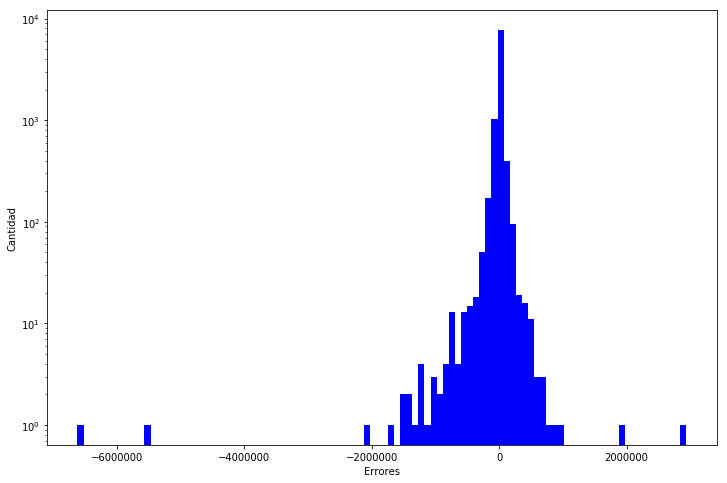

In [382]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()